# G3 Xe TPC Projections

Predict the spatial distribution and rate of the $\gamma$-ray background in the $^{136}$Xe 0nBB ROI for a generation-3 LXe TPC Experiment.

**How this works**:
The differential rate is modelled by,

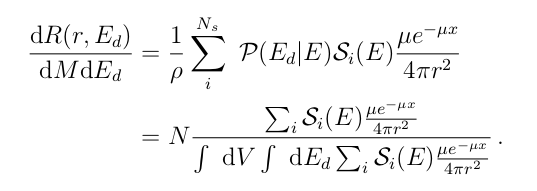

where,
* $N_s$ = number of sources
* $N$ = integrated rate in the TPC [events/yr]
* $S_i(E)$ = $\gamma$-ray energy spectrum
* $\mu$ = xenon attenuation coefficient (energy dep.)
* $x$ = distance travelled through LXe to point ($r, \theta, z$)
* $r$ = distance from source to LXe point ($r, \theta, z$)

$N$ is estimated using the total rate in the 0nBB ROI from the LZ simulations, and scaled by the increase in TPC surface area of a G3 experiment.

$S(E)$ is assumed to be $\delta(E-2447)$ to represnt the dominant $2,447$ keV background from $^{214}$Bi

Isotropic $\gamma$-ray sources are generated uniformly on surfaces that represent the PMTs and TPC walls.

**Note: this will give inaccurate results for sources displaced too far from the LXe. However, it matches the LZ and DARWIN spatrial distributions relatively well with PMT and TPC wall sources only. See the [validation notebook](validation.ipynb).**

In [70]:
import xedist # all the functionality is in the xedist module
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

**Define TPC dimensions**

In [71]:
# define tpc dimensions, (excluding reverse-field region and gas gap)
tpc = xedist.TPC(radius = 160, height = 320)

# define extra xenon due to gas and reverse field region:
rfr_height = 0.1 * tpc.height # cm
gas_gap_height = 0.8 # cm

# rough contamination levels of walls and PMTs (decays/area)
# Assume 10x rate from TPC than walls
# absolute numbers don't matter as we rescale to LZ total rate
# these numbers were tweaked to ensure the model can match the LZ sims (see validation.ipynb)
wall_surface_area = 2*np.pi*tpc.radius*(tpc.height+rfr_height+gas_gap_height)
wall_decays_per_area = 1e-2

array_surface_area = np.pi*tpc.radius**2 
array_decays_per_area = 10e-2

**Define $\gamma$-ray background sources**

$\gamma$-rays are uniformly generated on each of the defined surfaces (e.g disk and surface of cylinder)

Only the 2,447 keV $\gamma$-ray from $^{214}$Bi is assumed, as this is the dominant background

***Note***: the predictions are only accurate for backgrounds located very close to the LXe, i.e the PMTs and TPC walls. 
This is due to the fact that all space outside of the TPC is assumed to be LXe, and therefore the attenuation is massively overestimated for displaced sources.
To do this correctly, the distance travelled through the TPC needs to be separately calculated for each $\gamma$-ray but this functionality is not implemented for the sake of speed


In [72]:
energy = 2447 # keV

bottom_pmts = xedist.DiskGammaSource(tpc.radius+0.1, -rfr_height, energy, 
                              array_decays_per_area * array_surface_area)

top_pmts = xedist.DiskGammaSource(tpc.radius+0.1, tpc.height+gas_gap_height, energy, 
                           array_decays_per_area * array_surface_area)

tpc_walls = xedist.CylindricalGammaSource(tpc.radius+0.1, tpc.height+gas_gap_height+rfr_height, 
                                   (tpc.height-rfr_height+gas_gap_height)/2., energy, 
                                   wall_decays_per_area * wall_surface_area)

In [73]:
rate = xedist.spatial_distribution(tpc, bottom_pmts, top_pmts, tpc_walls)

Text(0, 0.5, 'z [cm]')

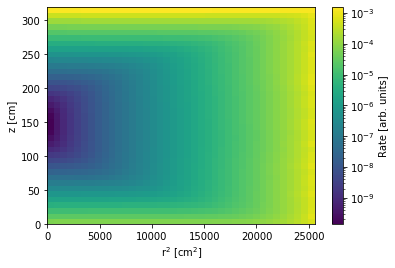

In [74]:
fig, ax = plt.subplots()

c = ax.pcolormesh(tpc.r2[:, 0, 0], tpc.z[0, 0, :], rate.T, norm=mpl.colors.LogNorm())
fig.colorbar(c, label='Rate [arb. units]')
ax.set_xlabel('r$^2$ [cm$^2$]')
ax.set_ylabel('z [cm]')


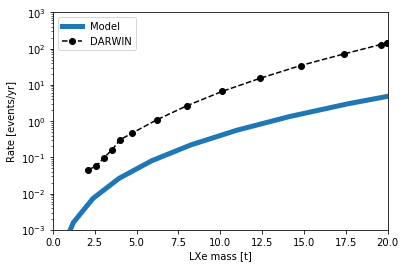

In [75]:
fig, ax = plt.subplots()

mass, diff_rate = xedist.get_cumulative_rate(rate, tpc)
ax.plot(mass, diff_rate, lw=5, label='Model')
ax.set_yscale('log')

darwin = np.genfromtxt("data/darwin_fv.txt", delimiter=',') # digitised from https://arxiv.org/pdf/2003.13407.pdf (units of events/tonne/yr/keV)
ax.plot(darwin[:,0], darwin[:,1] * darwin[:,0] * 50, ls='--', marker='o', c='black', label='DARWIN')

ax.set_xlim(0, 20)
ax.set_ylim(1E-3, 1E3)
ax.set_ylabel('Rate [events/yr]')
ax.set_xlabel('LXe mass [t]')
ax.legend()